# EDA

In [2]:
import cv2
import pytesseract 
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.animation
import numpy as np
import pandas as pd
import seaborn as sns
import math
from IPython.display import HTML
from scipy import stats
from scipy.signal import butter, lfilter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [3]:
def get_vo2_peak(row):
    sex = 0
    bmi = 0
    age = row.age
    if row.sex == 'F':
        sex=2
    else:
        sex=1
    if row.BMI <= 25:
        bmi = 0
    else:
        bmi = 1
    if age < 34:
        age = 1
    elif 34 <= age < 44:
        age = 2
    elif 44 <= age < 54:
        age = 3
    elif 54 <= age < 64:
        age = 4
    elif age >=64:
        age = 5
    peak_est = 47.7656 -0.9880*age-0.2356*age**2-8.8697*sex+2.3597*bmi-2.0308*age*bmi-3.7405*sex*bmi+0.2512*age*sex+1.3797*age*sex*bmi
    peak_est = peak_est * 10**-3 * row['weight-kg']
    return peak_est

In [4]:
patient_info = pd.read_excel('./data/DigitalDataEnriched.xlsx', sheet_name = 'Patient')
patient_info['BMI']=patient_info['weight-kg']/(patient_info['height-cm']/100)**2
patient_info.dropna(subset = ["sex"], inplace=True)
patient_info['MaxVO2_EST']=patient_info.apply(lambda x: get_vo2_peak(x),axis=1)
patient_info.head()

patientid sex  age  height-cm  weight-kg        BMI TypeExercise  \
0          7   F   40    162.560    94.9091  35.915381    Treadmill   
1          8   M   69    175.260   107.6818  35.057157    Treadmill   
2          9   F   16    160.528    49.3100  19.135218    Treadmill   
3         10   M   17    176.784    60.5000  19.358400    Treadmill   
4         11   F   15    179.070    66.0000  20.582507    Treadmill   

    TypePatient     FileName Condition Translator  PulmonaryLim  \
0       Unknown   CHF.1.xlsx        OK         JP             0   
1       Unknown   CHF.2.xlsx        OK         JP             0   
2  YoungAthlete  DEAS.1.xlsx        OK         JP             0   
3  YoungAthlete  DEAS.2.xlsx        OK         JP             0   
4  YoungAthlete  DEAS.3.xlsx        OK         JP             0   

   MuscleSkeletalLim  CardiacLim Observations  MaxVO2_EST  
0                  0           1          NaN    2.320385  
1                  0           1          NaN    2.658190  
2                  0           0          NaN    1.445030  
3                  0           0          NaN    2.294372  
4                  0           0          NaN    1.934130

## Patient's distributions

### By Gender

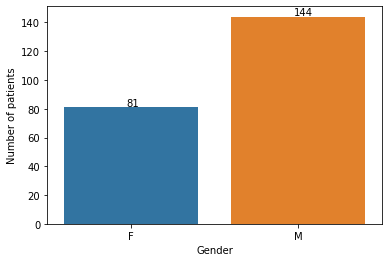

In [6]:
hue_order = ['Female', 'Male']
ax = sns.countplot(x="sex", data=patient_info, hue_order = hue_order)
plt.ylabel("Number of patients")
plt.xlabel("Gender")

for p in ax.patches:
    percentage = '{:.0f}'.format(p.get_height()/1)
    ax.annotate(percentage,(p.get_x()+p.get_width()/2-.03,p.get_y()+ p.get_height()+1))

plt.show()

### By Age

C:\Users\julio\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


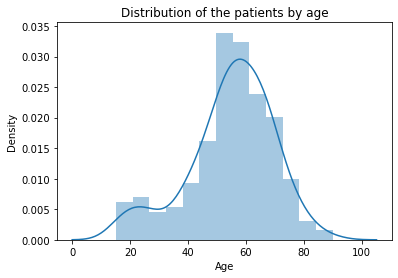

In [8]:
ax = sns.distplot(patient_info.age, rug=False, hist=True)
plt.xlabel("Age")
plt.title("Distribution of the patients by age") # You can comment this line out if you don't need title
plt.show(ax)

### By BMI

C:\Users\julio\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\julio\Anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


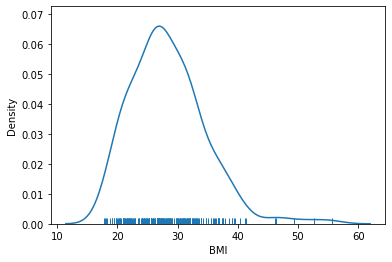

In [9]:
ax = sns.distplot(patient_info.BMI, rug=True, hist=False)

### By limitation

#### Cardiac Limitation

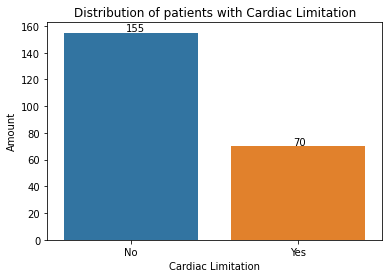

In [11]:
ax = sns.countplot(x="CardiacLim", data=patient_info)
plt.ylabel("Amount")
plt.xlabel("Cardiac Limitation")
plt.title("Distribution of patients with Cardiac Limitation") # You can comment this line out if you don't need title
ax.set_xticklabels(['No','Yes'])
for p in ax.patches:
    percentage = '{:.0f}'.format(p.get_height()/1)
    ax.annotate(percentage,(p.get_x()+p.get_width()/2-.03,p.get_y()+ p.get_height()+1))
plt.show(ax)

We have More than 90 CPET cases from the real cases and the book, 31% of them have a cardiac limitation from the book and observations from Dr. Andonian and Kraus. Given that the cardiac limitation is the only indicator that we are sure to have at the moment, we're going to use it for machine learning algorithms and is going to be the focus for the coming weeks. Further works from other capstone teams can be on other limitators, etc.

#### Pulmonary Limitation

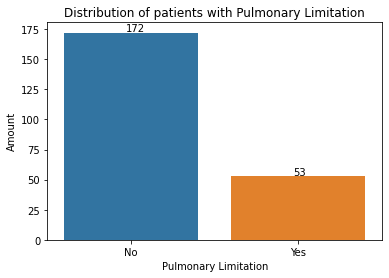

In [12]:
ax = sns.countplot(x="PulmonaryLim", data=patient_info)
plt.ylabel("Amount")
plt.xlabel("Pulmonary Limitation")
plt.title("Distribution of patients with Pulmonary Limitation") # You can comment this line out if you don't need title
ax.set_xticklabels(['No','Yes'])
for p in ax.patches:
    percentage = '{:.0f}'.format(p.get_height()/1)
    ax.annotate(percentage,(p.get_x()+p.get_width()/2-.03,p.get_y()+ p.get_height()+1))
plt.show(ax)

In [13]:
patient_info.groupby(by='PulmonaryLim').agg('count').patientid/patient_info.shape[0]

PulmonaryLim
0    0.764444
1    0.235556
Name: patientid, dtype: float64

#### Muscle Skeletal

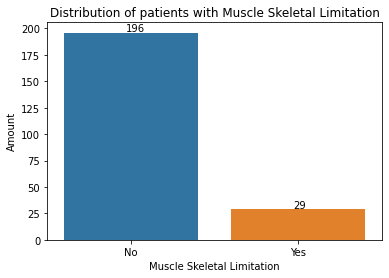

In [14]:
ax = sns.countplot(x="MuscleSkeletalLim", data=patient_info)
plt.ylabel("Amount")
plt.xlabel("Muscle Skeletal Limitation")
plt.title("Distribution of patients with Muscle Skeletal Limitation") # You can comment this line out if you don't need title
ax.set_xticklabels(['No','Yes'])
for p in ax.patches:
    percentage = '{:.0f}'.format(p.get_height()/1)
    ax.annotate(percentage,(p.get_x()+p.get_width()/2-.03,p.get_y()+ p.get_height()+1))
plt.show(ax)

In [15]:
patient_info.groupby(by='MuscleSkeletalLim').agg('count').patientid/patient_info.shape[0]

MuscleSkeletalLim
0    0.871111
1    0.128889
Name: patientid, dtype: float64